
# Time Series Forecasting

In continuation of my BLS series, we will examine the _Cosumer Price Index_ and its relatedness to Inflation.

- Seas: Seasonal Adjustment (SA) is a method of adjusting for seasonal variations in economic factors.
- Unadj: Unadjusted (U) is the original value of the economic factor.
- CPI-U-Median: Consumer Price Index (CPI) is a measure of the price level of the U.S. economy.
- CPI-U-RS: Consumer Price Index (CPI) is a measure of the price level of the U.S. economy.

## Libraries

In [ ]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import itertools
import statsmodels as sm
from pathlib import Path

from scipy.signal import *
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf


from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
#from numpy import array


#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
plt.style.use('seaborn-white')
%matplotlib inline

#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
#from nimbusml.timeseries import SsaForecaster
from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler


# Application of R in Python 
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
 

import warnings
warnings.filterwarnings("ignore")
np.random.seed(786)

print('Pandas:', pd.__version__)
print('Rpy2:', rpy2.__version__)
print('Statsmodels:', sm.__version__)
print('Scipy:', scipy.__version__)

Pandas: 1.3.5
Rpy2: 3.4.5
Statsmodels: 0.10.2
Scipy: 1.4.1


## Matplotlib Defaults

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",     
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

#### Plotly

In [ ]:
def iterate_months(df):
    # We will iterate through the months
    for i in range(1, len(df)):
    #yeild return our month/year index
        yield df.iloc[i]['Jan'], df.iloc[i]['Year']
        
        
def filter_values(value):
    # Filter the values to .2f
    return round(value, 2)

In [ ]:
fig = px.line(ces_total_nf, x='Year', y='Jun', title='Consumer Price Index',
              labels={'Year': 'Year', 'Jun': 'Consumer Expenditure Survey'})

fig.update_layout(
    title_text='Consumer Expenditure Survey',
    xaxis_title_text="Year",
    yaxis_title_text="Jun",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color = '#1f77b4'
    )
)
iplot(fig)

## Custom functions 

In [ ]:
# Define some custom functions to help the analysis


def MAPE(y_true, y_pred): 
    """
    %Error compares true value with predicted value. Lower the better. Use this 
    along with rmse(). If the series has 
    outliers, compare/select model using MAPE instead of rmse()
    
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals 
    should be uncorrelated, zero mean, constant variance and normally distributed. 
    First two are must, while last two are good to have. If the first two are not
    met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
    
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. 
    Some lags might still be significant. 
    
    Lags should be min(2*seasonal_period, T/5)
    
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
    
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(ljung(x=residuals, lags=lags)[1])
    norm_p_val =  jb(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
    
    
    
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", np.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3), "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    
    
    return ts_ax, acf_ax, kde_ax

    
def accuracy(y1,y2):
    
    accuracy_df=pd.DataFrame()
    
    rms_error = np.round(rmse(y1, y2),1)
    
    map_error = np.round(np.mean(np.abs((np.array(y1) - np.array(y2)) / np.array(y1))) * 100,1)
           
    accuracy_df=accuracy_df.append({"RMSE":rms_error, "%MAPE": map_error}, ignore_index=True)
    
    return accuracy_df

def plot_pgram(series,diff_order):
    """
    This function plots thd Power Spectral Density of a de-trended series. 
    PSD should also be calculated for a de-trended time series. Enter the order 
    of differencing needed
    Output is a plot with PSD on Y and Time period on X axis
    
    Series: Pandas time series or np array
    differencing_order: int. Typically 1
    
    """
    #from scipy import signal    
    de_trended = series.diff(diff_order).dropna()
    f, fx = signal.periodogram(de_trended)
    freq=f.reshape(len(f),1) #reshape the array to a column
    psd = fx.reshape(len(f),1)
    #plt.figure(figsize=(5, 4)
    plt.plot(1/freq, psd  )
    plt.title("Periodogram")
    plt.xlabel("Time Period")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    

## Data Importation

In [ ]:
path = '/content/cpi_all.csv'

# Sales numbers are in thousands, so I am dividing by 1000 to make it easier to 
# work with numbers, especially squared errors
cpi = pd.read_csv(path, parse_dates=True, index_col="Year").T#.div(1_000)

#data.index.freq='M'

cpi.head()  

Year,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01
Jan,226.665,230.280,233.916,233.707,236.916,242.839,247.867,251.712,257.971,261.582
Feb,227.663,232.166,234.781,234.722,237.111,243.603,248.991,252.776,258.678,263.014
Mar,229.392,232.773,236.293,236.119,238.132,243.801,249.554,254.202,258.115,264.877
Apr,230.085,232.531,237.072,236.599,239.261,244.524,250.546,255.548,256.389,267.054
May,229.815,232.945,237.900,237.805,240.229,244.733,251.588,256.092,256.394,269.195


In [ ]:
path2 = '/content/cpi_all.csv'

df = pd.read_csv(path2)

#data.index.freq='M'

df.head() 

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2012,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601
1,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049
2,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812
3,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525
4,2016,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432


## EDA

In [ ]:
cpi.index

Index(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec'],
      dtype='object')

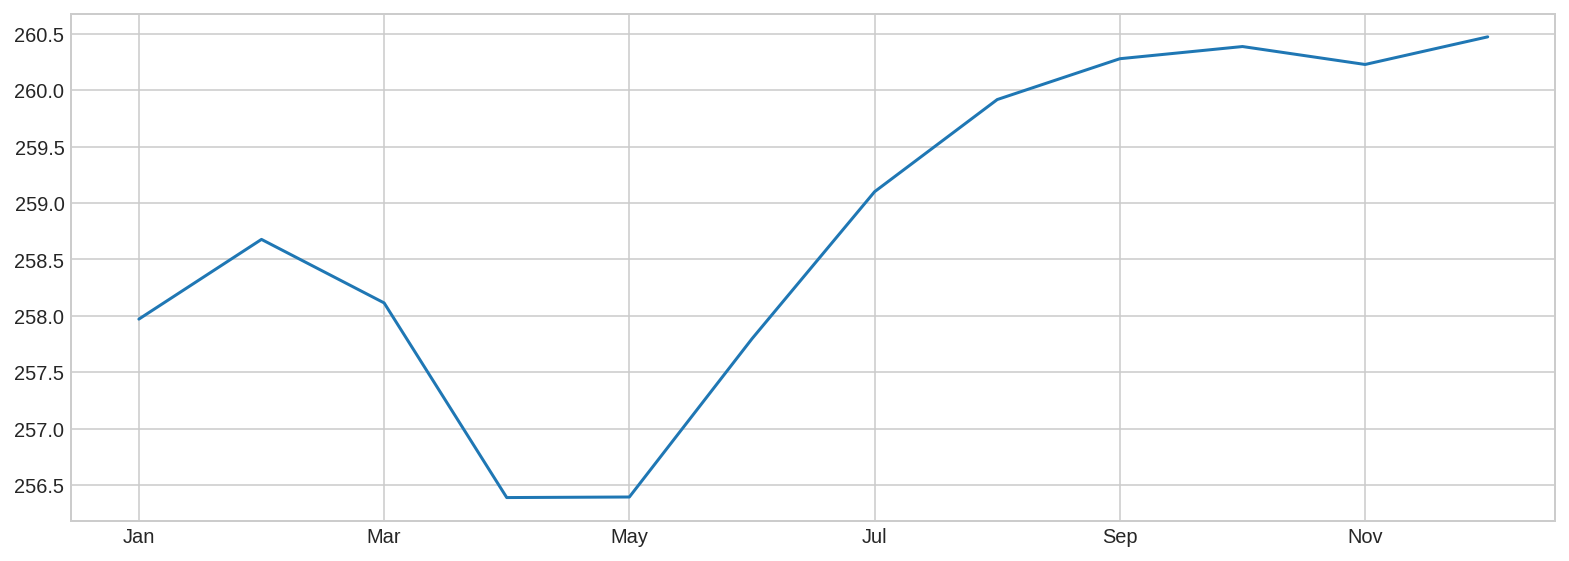

In [ ]:
cpi['2020-01-01'].plot();

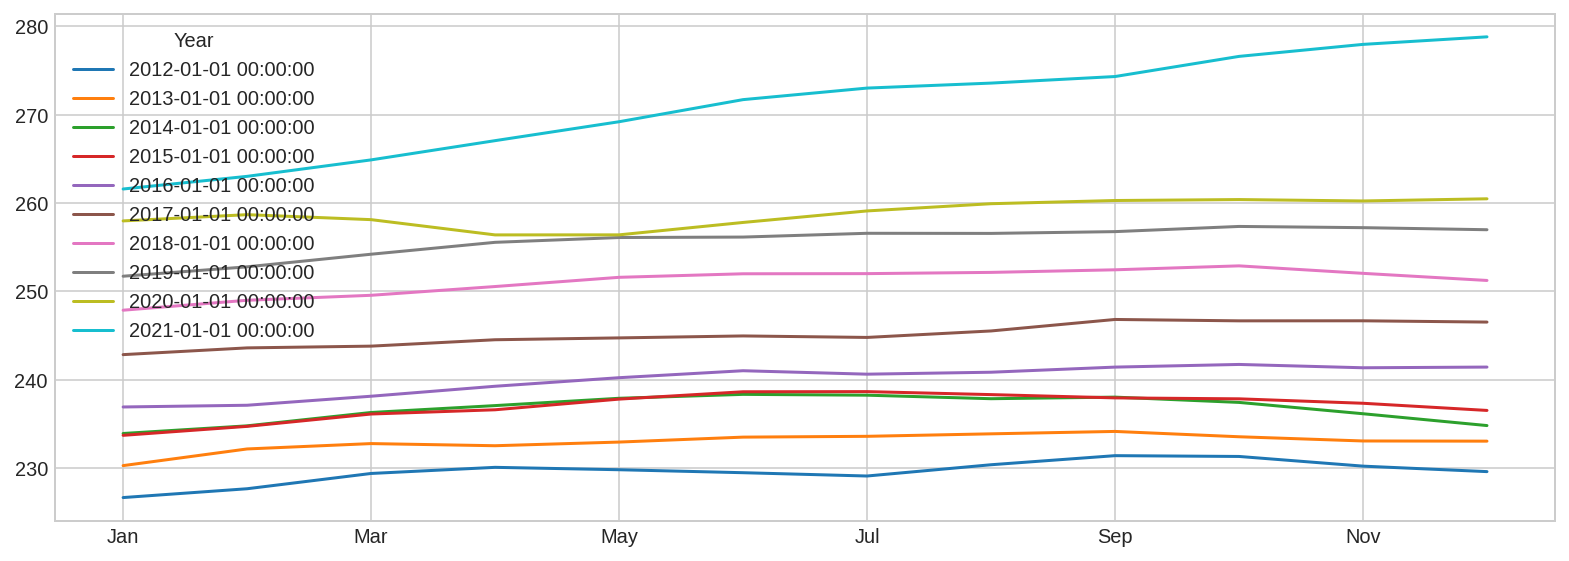

In [ ]:
cpi[:].plot();

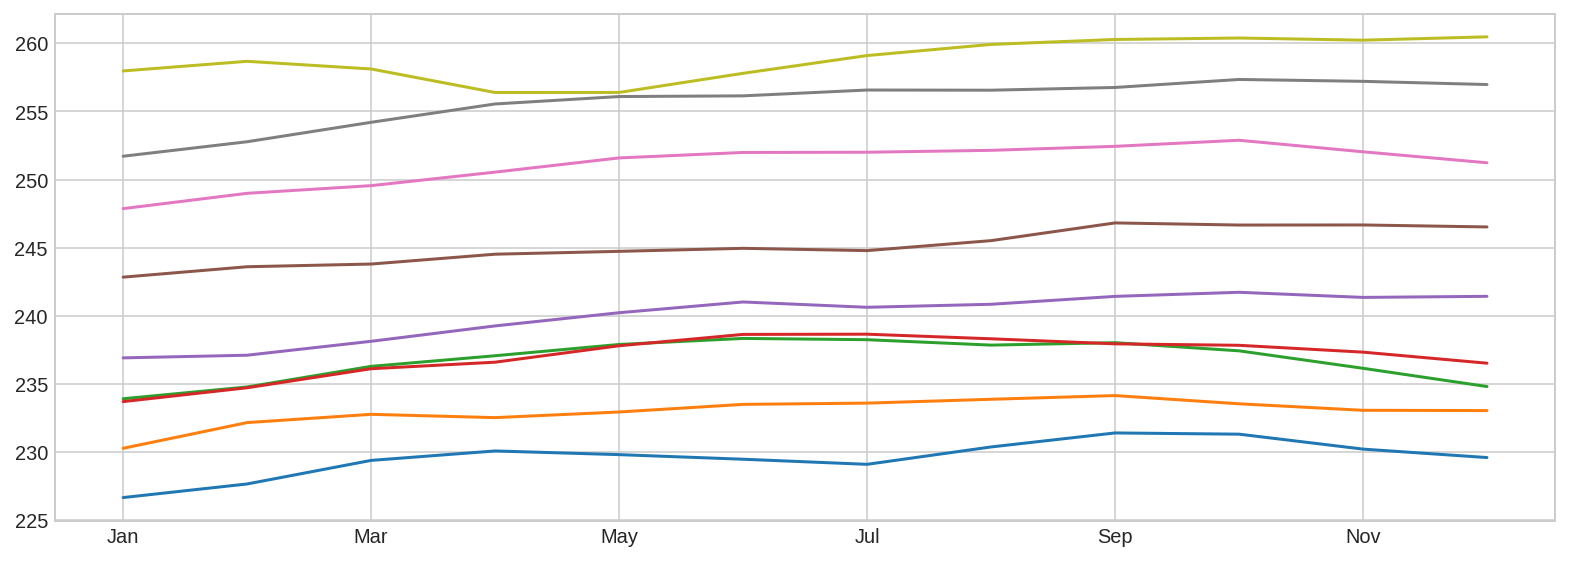

In [ ]:
cpi['2012-01-01'].plot()
cpi['2013-01-01'].plot()	
cpi['2014-01-01'].plot()	
cpi['2015-01-01'].plot()	
cpi['2016-01-01'].plot()	
cpi['2017-01-01'].plot()	
cpi['2018-01-01'].plot()	
cpi['2019-01-01'].plot()	
cpi['2020-01-01'].plot();

#### Monthly plots

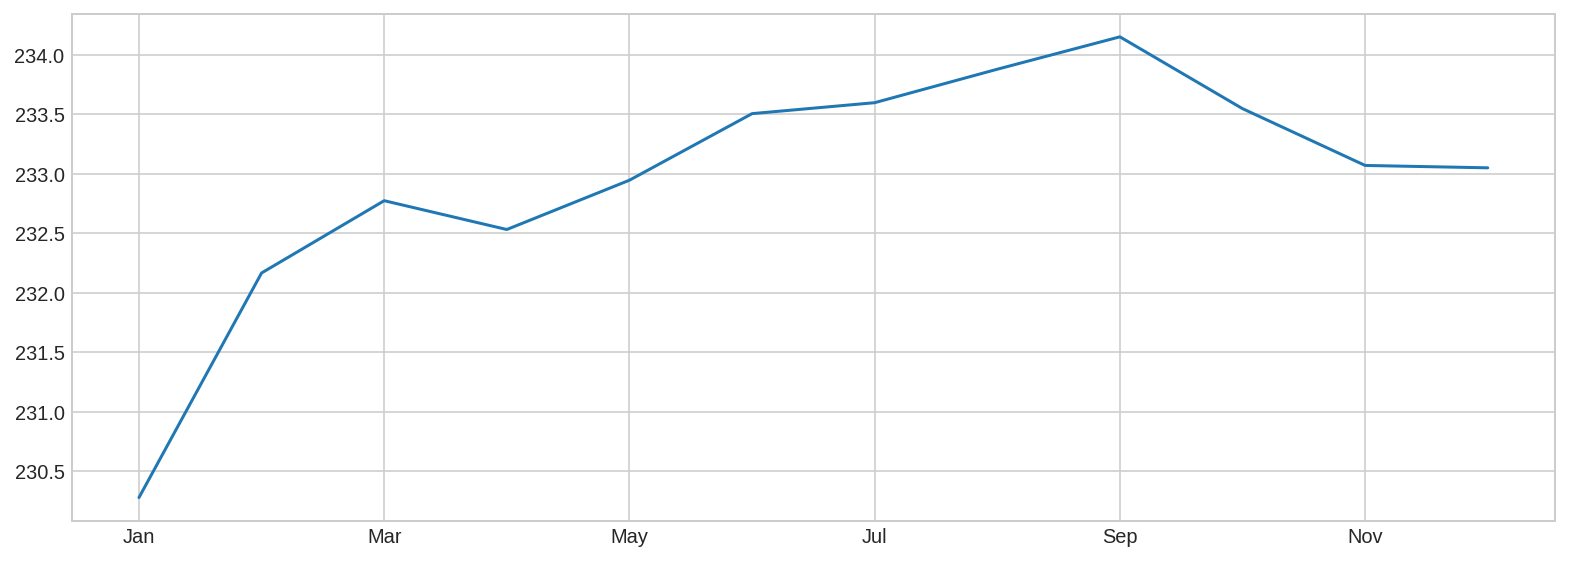

In [ ]:
cpi['2013-01-01'].plot();	


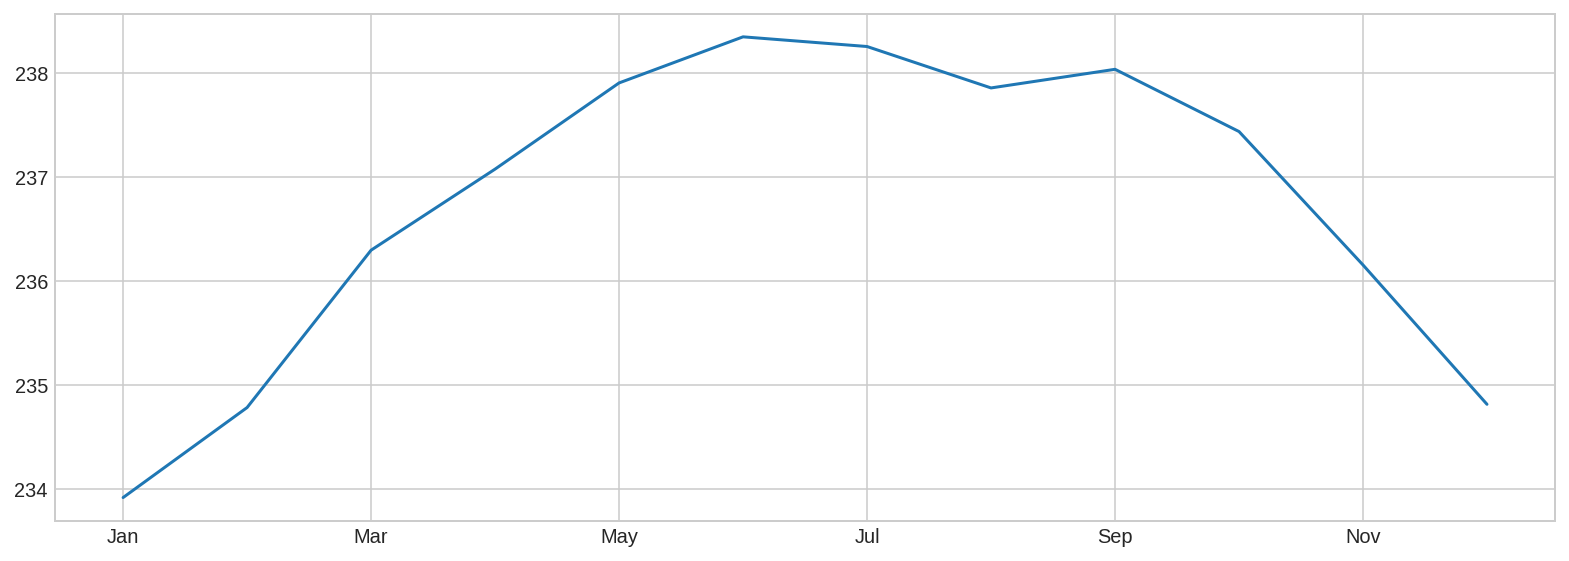

In [ ]:
cpi['2014-01-01'].plot();

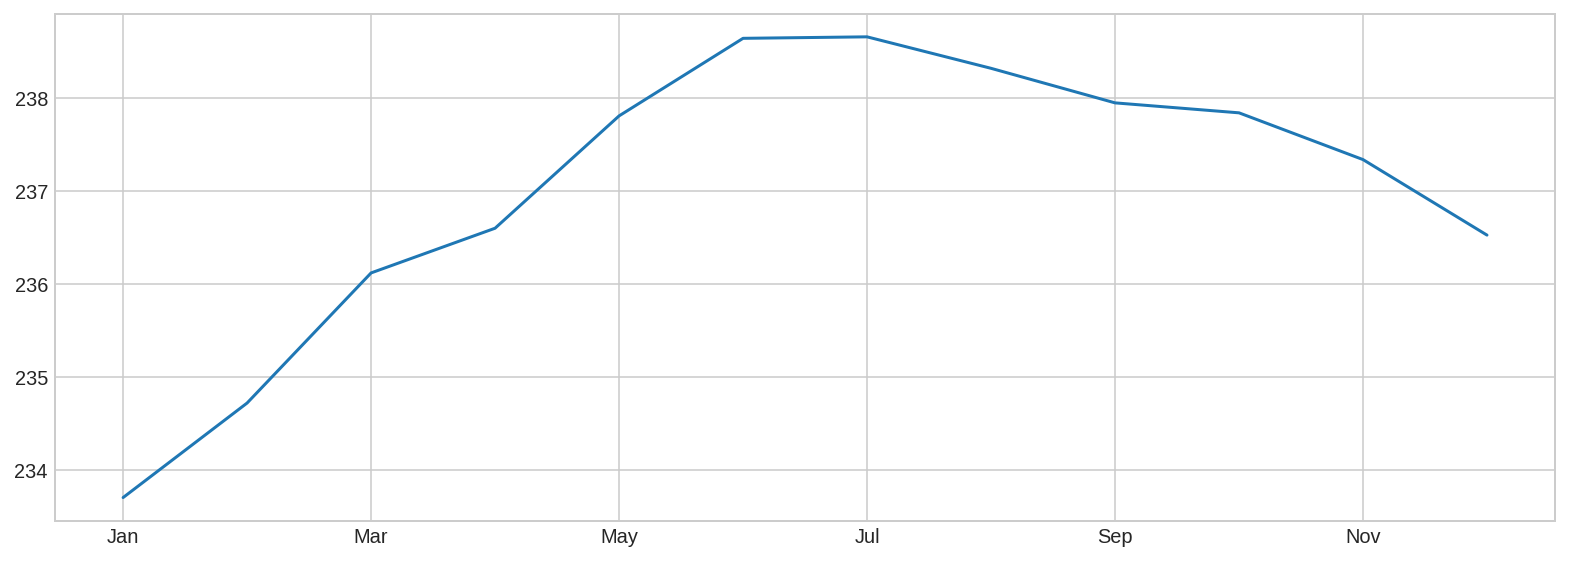

In [ ]:
cpi['2015-01-01'].plot();

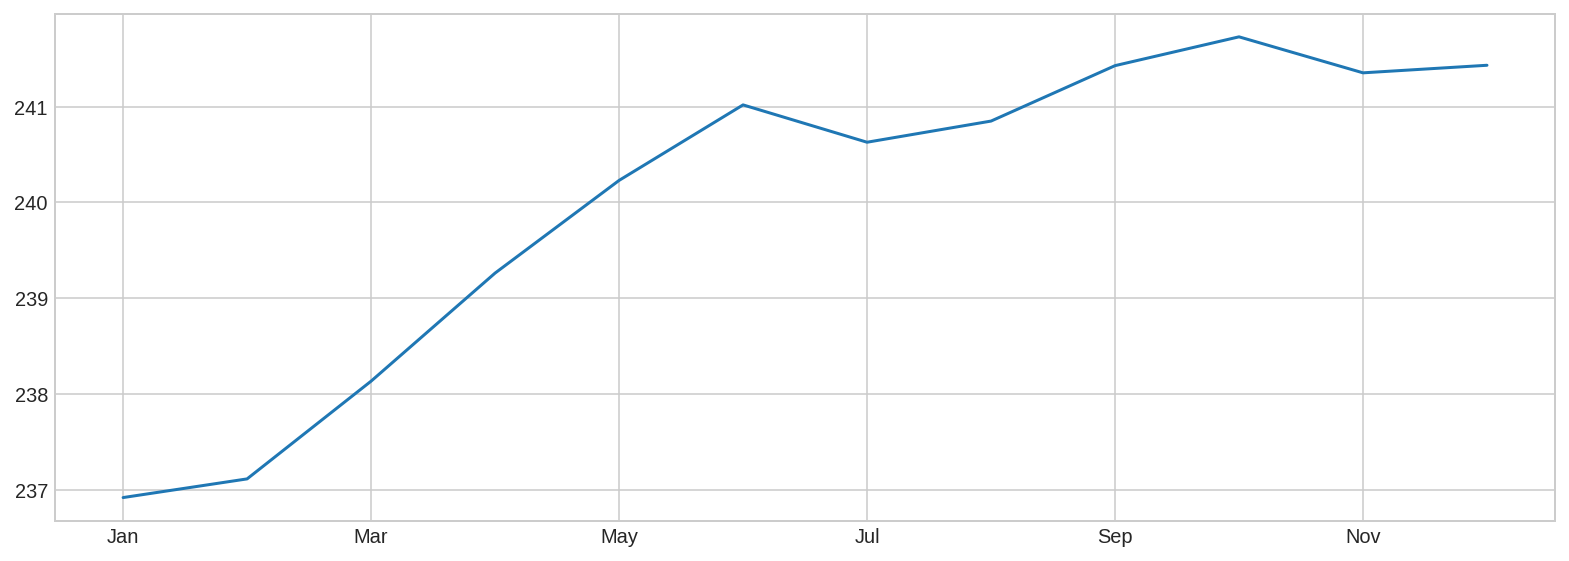

In [ ]:
cpi['2016-01-01'].plot();

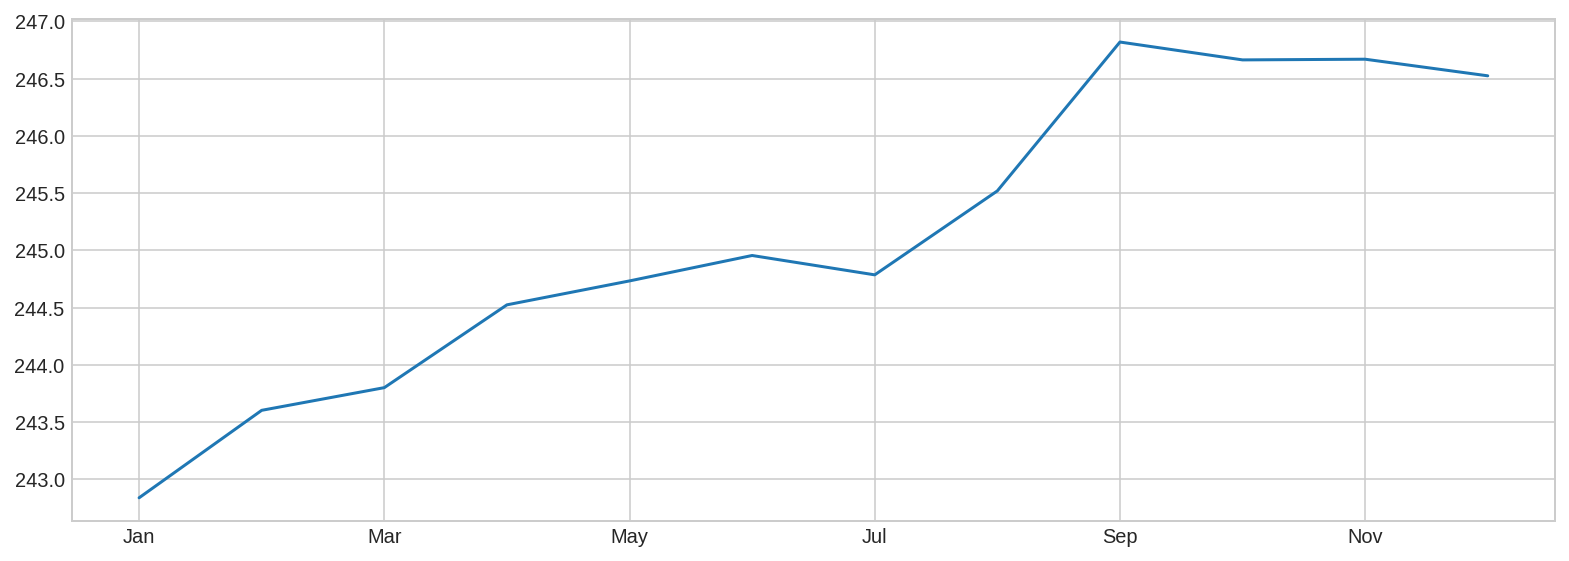

In [ ]:
cpi['2017-01-01'].plot();

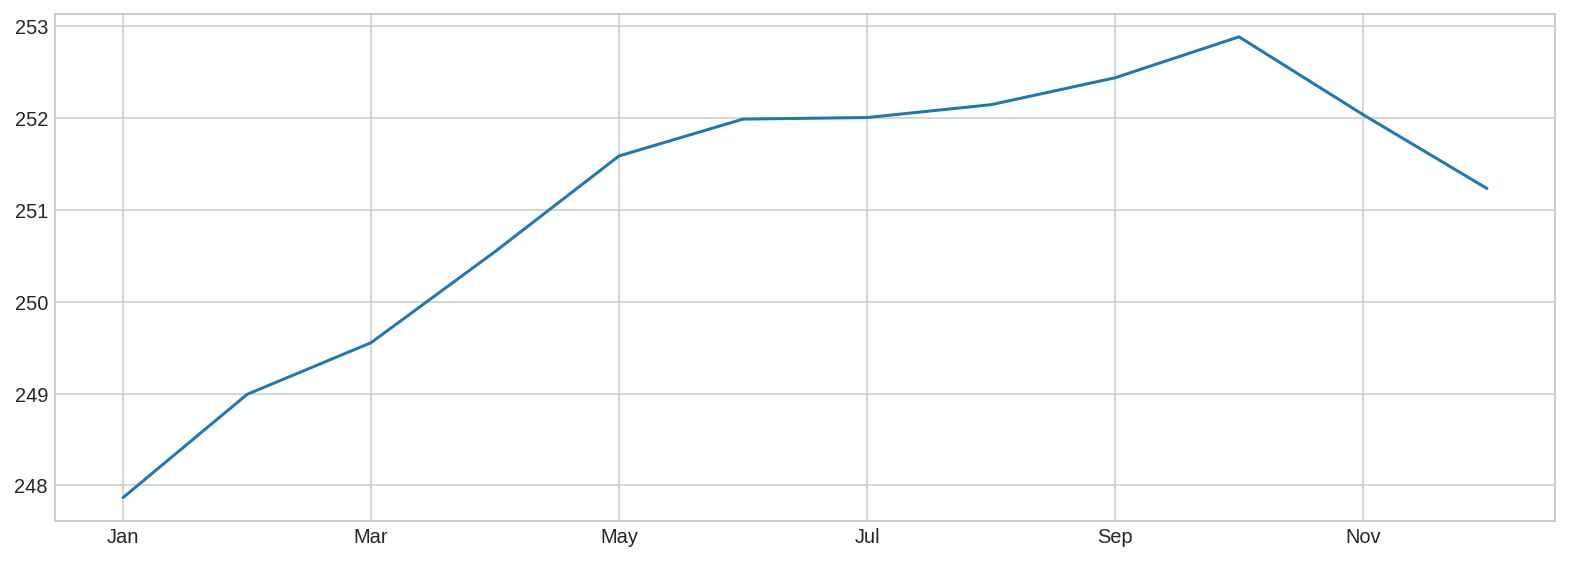

In [ ]:
cpi['2018-01-01'].plot();

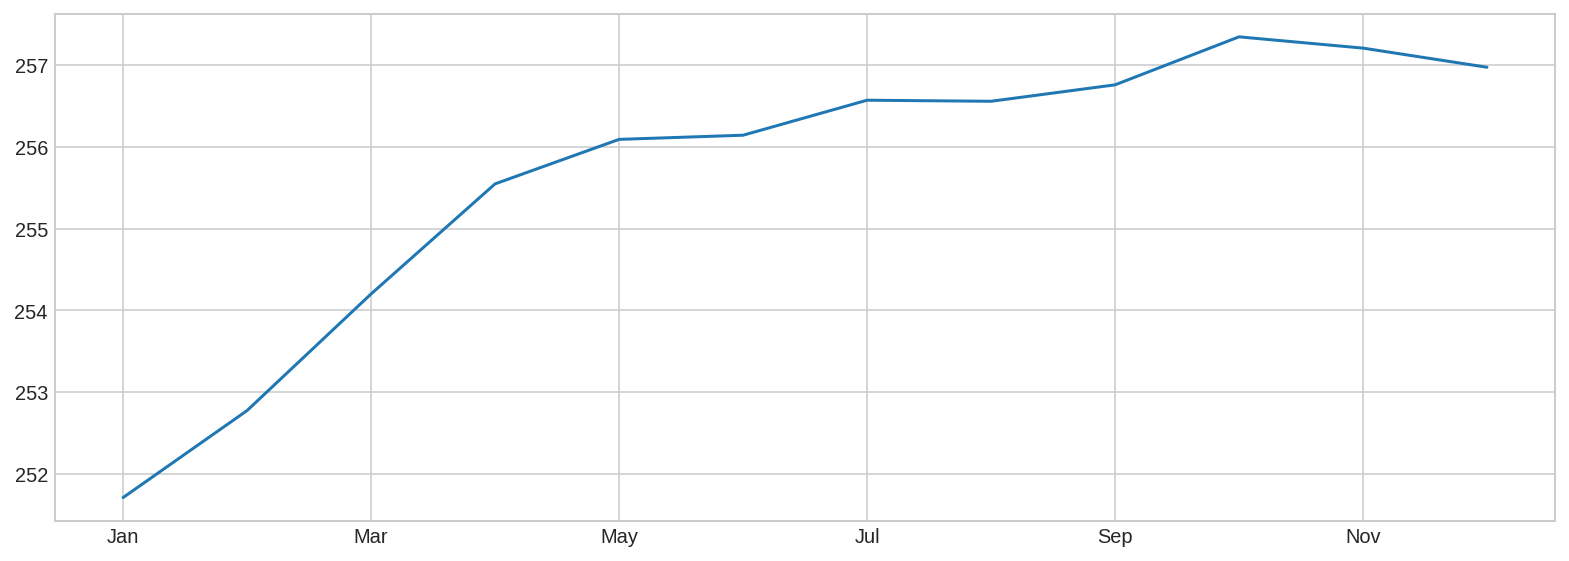

In [ ]:
cpi['2019-01-01'].plot();

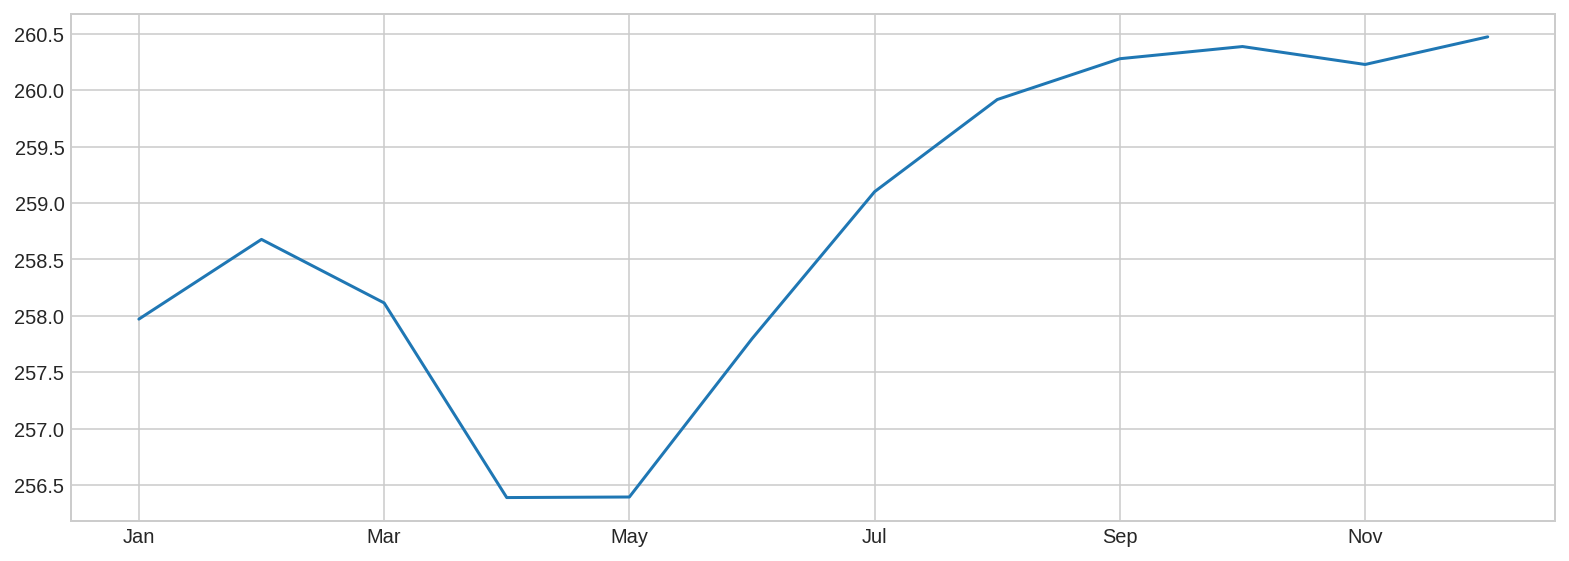

In [ ]:
cpi['2020-01-01'].plot();

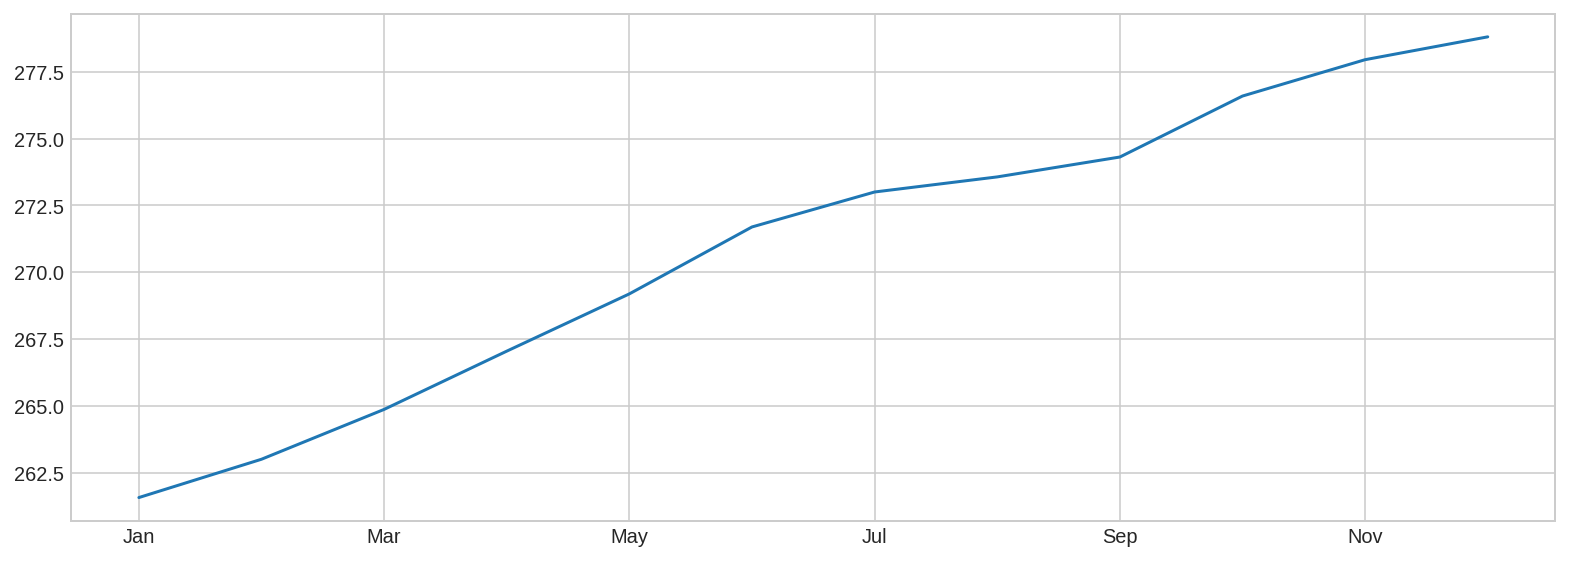

In [ ]:
cpi['2021-01-01'].plot();

# Split Dataset

In [ ]:
X_train, x_test, y_train, y_test = train_test_split(cpi, )

In [ ]:
#Split into train and test
train = cpi.iloc[:-3]
test  = cpi.iloc[-3:]
#forecast horizon
h = 12
train_length = len(train)

print('train_length:',train_length, '\n test_length:', len(test) )

train_length: 9 
 test_length: 3


In [ ]:
train.head()

Year,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01
Jan,226.665,230.280,233.916,233.707,236.916,242.839,247.867,251.712,257.971,261.582
Feb,227.663,232.166,234.781,234.722,237.111,243.603,248.991,252.776,258.678,263.014
Mar,229.392,232.773,236.293,236.119,238.132,243.801,249.554,254.202,258.115,264.877
Apr,230.085,232.531,237.072,236.599,239.261,244.524,250.546,255.548,256.389,267.054
May,229.815,232.945,237.900,237.805,240.229,244.733,251.588,256.092,256.394,269.195


In [ ]:
#create white noise with N(0,1.5), 500 points
np.random.seed(578)
steps = np.random.normal(0,1,500)

noise = pd.DataFrame({"x":steps})
wnoise_chart = alt.Chart(noise.reset_index()).mark_line().encode(
    x='index', 
    y='x').properties(
    title="White Noise")

#Create random walk with N(0,1.5), 500 points

steps[0]=0
rwalk = pd.DataFrame({"x":100 + np.cumsum(steps)}).reset_index()
rwalk_chart = alt.Chart(rwalk).mark_line().encode(
    x='index', 
    y=alt.Y('x', scale=alt.Scale(domain=(80,150)))).properties(
    title="Random Walk")


wnoise_chart | rwalk_chart


alt.HConcatChart(...)

In [ ]:
#creating intermittent demand plot
demand = [10, 12, 0, 3,50,0,0,18,0,4, 12,0,0,8,0,3]
demanddf = pd.DataFrame({'y': demand, 'x': np.arange(2000, 2016) } )
alt.Chart(demanddf).mark_bar().encode(
    x='x',
    y='y').properties(
    title="Example: Intermittent Demand", width = 700)

alt.Chart(...)

In [ ]:
#Any missing data?
print("missing_data:", train.isna().sum())
print("unique dates:", train.index.nunique())

missing_data: Year
2012-01-01    0
2013-01-01    0
2014-01-01    0
2015-01-01    0
2016-01-01    0
2017-01-01    0
2018-01-01    0
2019-01-01    0
2020-01-01    0
2021-01-01    0
dtype: int64
unique dates: 9


In [ ]:
pd.crosstab(index=train.index.[0], columns=train.index.month)

SyntaxError: ignored

# Time Series

In [ ]:
df = pd.read_csv('/content/cpi_all.csv')
df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2012,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601
1,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049
2,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812
3,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525
4,2016,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    10 non-null     int64  
 1   Jan     10 non-null     float64
 2   Feb     10 non-null     float64
 3   Mar     10 non-null     float64
 4   Apr     10 non-null     float64
 5   May     10 non-null     float64
 6   Jun     10 non-null     float64
 7   Jul     10 non-null     float64
 8   Aug     10 non-null     float64
 9   Sep     10 non-null     float64
 10  Oct     10 non-null     float64
 11  Nov     10 non-null     float64
 12  Dec     10 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 1.1 KB


In [ ]:
df['Year'] = df['Year'].apply(pd.to_datetime, format="%Y")
df.head(2)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2012-01-01,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601
1,2013-01-01,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049



#### Moving Average

# R - Plots

In [ ]:
# Create line chart for Training data. Index is reset to use Date column
train_chart=alt.Chart(train.reset_index()).mark_line(point=True).encode(
    x='Year', 
    y='Jan', 
    tooltip=['Year', 'Jan'])

#Create Rolling mean. This centered rolling mean 
rolling_mean = alt.Chart(train.reset_index()).mark_trail(
    color='orange',
    size=1
).transform_window(
    rolling_mean='mean(Sales)',
    frame=[-4,4]
).encode(
    x='Date:T',
    y='rolling_mean:Q',
    size='Sales'
)

#Add data labels
text = train_chart.mark_text(
    align='left',
    baseline='top',
    dx=5  # Moves text to right so it doesn't appear on top of the bar
).encode(
    text='Sales:Q'
)

#Add zoom-in/out
scales = alt.selection_interval(bind='scales')

#Combine everything
(train_chart + rolling_mean +text).properties(
    width=600, 
    title="French Retail Sales & 4Q Rolling mean ( in '000)").add_selection(
    scales
)